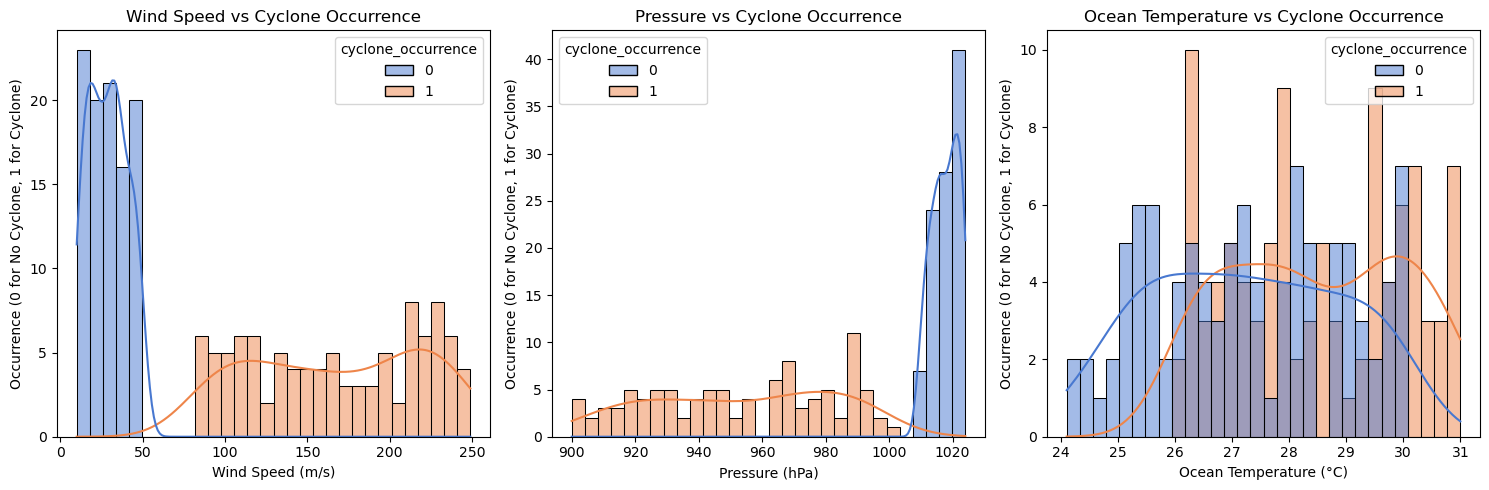

Alert sent to +918125112799
Cyclone Prediction for Visakhapatnam: Cyclone Probability: 0.09%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import requests
from twilio.rest import Client

# Load dataset
df = pd.read_csv(r'C:\Users\svr06\HackSavvy\Cyclone\cyclone_databased_on_weather.csv')

# Dropping non-numerical values
df = df.select_dtypes(include=[np.number])

# Split dataset into features and target
X = df.drop(columns=['cyclone_occurrence']) 
y = df['cyclone_occurrence']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Data visualization
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.histplot(data=df, x='wind_speed', hue='cyclone_occurrence', kde=True, bins=30, palette="muted", ax=axes[0])
axes[0].set_title("Wind Speed vs Cyclone Occurrence")
axes[0].set_xlabel("Wind Speed (m/s)")
axes[0].set_ylabel("Occurrence (0 for No Cyclone, 1 for Cyclone)")

sns.histplot(data=df, x='pressure', hue='cyclone_occurrence', kde=True, bins=30, palette="muted", ax=axes[1])
axes[1].set_title("Pressure vs Cyclone Occurrence")
axes[1].set_xlabel("Pressure (hPa)")
axes[1].set_ylabel("Occurrence (0 for No Cyclone, 1 for Cyclone)")

sns.histplot(data=df, x='ocean_temperature', hue='cyclone_occurrence', kde=True, bins=30, palette="muted", ax=axes[2])
axes[2].set_title("Ocean Temperature vs Cyclone Occurrence")
axes[2].set_xlabel("Ocean Temperature (°C)")
axes[2].set_ylabel("Occurrence (0 for No Cyclone, 1 for Cyclone)")

plt.tight_layout()
plt.show()

# Get real-time weather data
def get_weather_data(city):
    API_KEY = "6507970bb83d81c07cae186e70be9ff4"
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url).json()
    
    wind_speed = response['wind']['speed']
    pressure = response['main']['pressure']
    ocean_temperature = response['main']['temp']

    feature_names = ['wind_speed', 'pressure', 'ocean_temperature']
    return pd.DataFrame([[wind_speed, pressure, ocean_temperature]], columns=feature_names)

# Predicting occurence of cyclone based on real-time data using API
def predict_cyclone(city):
    data = get_weather_data(city)
    prob = model.predict_proba(data)[0,1]
    if 1 > 0.85:
        send_alert(f"Cyclone Warning for {city}! Take precautions.", "+918125112799")
        return f"Cyclone Probability: {prob:.2f}%"
    return "No Significant Cyclone Risk"

# Send SMS alert
def send_alert(message, phone_number):
    TWILIO_SID = "AC70aca667adeea1e83f651bfffab15c9e"
    TWILIO_AUTH_TOKEN = "4cab5134857cdd3ffe8cfc6243f06572"
    TWILIO_PHONE_NUMBER = "+15186201822"
    
    client = Client(TWILIO_SID, TWILIO_AUTH_TOKEN)
    message = client.messages.create(
        body=message,
        from_=TWILIO_PHONE_NUMBER,
        to=phone_number
    )
    print("Alert sent to", phone_number)

city = "Visakhapatnam"
prediction = predict_cyclone(city)
print(f"Cyclone Prediction for {city}: {prediction}")

if prediction == "Cyclone Risk Detected":
    send_alert(f"Cyclone Warning for {city}! Take precautions.", "+918125112799")